In [1]:
import os

assert os.environ['CONDA_DEFAULT_ENV']=='ttv'

In [2]:
import pandas as pd

dfs = []
for f in ['tics_resonance_from_toi', 'tics_resonance_from_ctoi', 'name_resonance_from_nexsci']:
    df = pd.read_csv(f'../data/{f}.csv', index_col=0)
    dfs.append(df)
#     print(df)

In [3]:
pd.concat(dfs).sort_values(by='delta_min')

,tic,delta_min,1st order,2nd order,name
7,441798995.0,0.000023,True,False,NaN
80,NaN,0.000024,False,True,Kepler-87
44,NaN,0.000035,True,True,Kepler-223
2,142276270.0,0.000091,True,False,NaN
71,NaN,0.000152,True,False,Kepler-50
...,...,...,...,...,...
29,344927749.0,0.009826,False,True,NaN
40,NaN,0.009857,True,True,Kepler-197
15,NaN,0.009875,True,True,K2-381
70,NaN,0.009925,True,True,Kepler-49


## create files

In [4]:
import sys
sys.path.insert(0, '../code')
from utils import *

tois = get_tois()

Loaded:  ../data/TOIs.csv


In [4]:
toiid=5671
name=f'toi{str(toiid).zfill(4)}'
name

'toi5671'

In [7]:
tois.query(f"TOI=={toiid}.01")

,TIC ID,TOI,Previous CTOI,Master,SG1A,SG1B,SG2,SG3,SG4,SG5,...,Stellar Radius (R_Sun) err,Stellar Metallicity,Stellar Metallicity err,Stellar Mass (M_Sun),Stellar Mass (M_Sun) err,Sectors,Date TOI Alerted (UTC),Date TOI Updated (UTC),Date Modified,Comments
4850,23863105,5671.01,NaN,3,4,4,3,2,4,4,...,0.01,NaN,NaN,0.400962,0.020565,50,2022-07-07,2022-07-07,2023-06-20 00:00:00,correct source of signal previously released o...


In [8]:
tic = 23863105 #384984325

In [9]:
d = tois[tois['TIC ID'].apply(str).str.contains(str(tic))].reset_index(drop=True)
d

,TIC ID,TOI,Previous CTOI,Master,SG1A,SG1B,SG2,SG3,SG4,SG5,...,Stellar Radius (R_Sun) err,Stellar Metallicity,Stellar Metallicity err,Stellar Mass (M_Sun),Stellar Mass (M_Sun) err,Sectors,Date TOI Alerted (UTC),Date TOI Updated (UTC),Date Modified,Comments
0,23863105,5671.01,NaN,3,4,4,3,2,4,4,...,0.01,NaN,NaN,0.400962,0.020565,50,2022-07-07,2022-07-07,2023-06-20 00:00:00,correct source of signal previously released o...


In [10]:
Teff, Teff_err, radius, radius_err, mass, mass_err = catalog_info_TIC(int(tic))

In [11]:
try:
#Teff, Teff_err, radius, radius_err, mass, mass_err = 3691, 157, 0.532243, 0.0158087, 0.529004, 0.0202865
    Teff, Teff_err, radius, radius_err, mass, mass_err = catalog_info_TIC(int(tic))
except Exception as e:
    print(e)

In [12]:
from pathlib import Path

# !mkdir ../allesfitter/$name
outdir = Path('../allesfitter', name)
outdir.mkdir(parents=True, exist_ok=True)

In [13]:
import numpy as np

debug = True

Nsamples = 10_000
planets = "b c d e f g h i".split()
# quartiles = [16,50,84] #1-sigma
quartiles = [2.70, 50, 97.3] #3-sigma
text = """
#name,value,fit,bounds,label,unit,truth
"""

for i,row in d.iterrows():
    tic = row['TIC ID']
    Porb = row['Period (days)']
    Porberr = row['Period (days) err']
    Porb_s = np.random.normal(Porb, Porberr, size=Nsamples)
    epoch = row['Epoch (BJD)']
    epocherr = row['Epoch (BJD) err']
    
    pl = planets[i]
    rprs = np.sqrt(row['Depth (ppm)']/1e6)
    rprserr = np.sqrt(row['Depth (ppm) err']/1e6)
    
    rprs_s = np.random.normal(rprs, rprserr, size=Nsamples)
    rprs_min, rprs, rprs_max = np.percentile(rprs_s, q=quartiles)
    
    Teff, Teff_err, radius, radius_err, mass, mass_err = catalog_info_TIC(tic)
    
    mass_s = np.random.normal(mass, mass_err, size=Nsamples)
    radius_s = np.random.normal(radius, radius_err, size=Nsamples)
    
    rho_s = rho_from_mr(mass_s, radius_s)
    as_s = as_from_rhop(rho_s, Porb_s)
    if debug:
        rhomin, rho, rhomax = np.percentile(rho_s, q=quartiles)
        as_min, a, as_max = np.percentile(as_s, q=quartiles)
        a_au_s = a_from_rhoprs(rho_s, Porb_s, radius_s)
        a_au_min, a_au, a_au_max = np.percentile(a_au_s, q=quartiles)
    
    rsuma_s = radius_s/as_s
    rsuma_min, rsuma, rsuma_max = np.percentile(rsuma_s, q=quartiles)
    
    theta = np.arcsin(radius_s/as_s)
    inc_s = np.pi/2 - theta
    inc_max, inc, inc_min = np.percentile(inc_s, q=quartiles)
    if debug:
        b_s = as_s * np.cos(inc_s)
        b_min, b, b_max = np.percentile(b_s, q=quartiles)
    
    text += f"#companion {pl} astrophysical params,,,,,,\n"
    text += f"{pl}_rr,{rprs:.4f},1,uniform {0} {rprs_max:.4f},$R_{pl} / R_\star$,,\n"
#     text += f"{pl}_rr,{rprs:.4f},1,trunc_normal 0 1 {rprs:.4f} {rprserr:.4f},$R_{pl} / R_\star$,,\n"
    text += f"{pl}_rsuma,{rsuma:.4f},1,uniform {rsuma_min:.4f} 0.1,$(R_\star + R_{pl}) / a_{pl}$,,\n"
#     text += f"{pl}_cosi,{np.cos(inc):.4f},1,uniform {np.cos(inc_min):.4f} {np.cos(inc_max):.4f},$\cos"+"{i_"+pl+"}$,,\n"
    text += f"{pl}_cosi,0,1,uniform 0 1,$\cos"+"{i_"+pl+"}$,,\n"
#     text += f"{pl}_epoch,{epoch:.2f},1,uniform {epoch-epoch_err:.4f} {epoch+epoch_err:.4f},$T_"+"{0;"+pl+"}$,BJD,"
    text += f"{pl}_epoch,{epoch:.2f},1,normal {epoch:.4f} {epocherr:.4f},$T_"+"{0;"+pl+"}$,BJD,\n"
    text += f"{pl}_period,{Porb:.4f},1,normal {Porb:.4f} {Porberr:.4f},$P_b$,d,\n"
    if debug:
        print(pl)
        print(f"rprs={rprs:.4f}")
        print(f"rho={rho:.4f}")
        print(f"a_s={a:.4f}")
        print(f"a_au={a_au:.4f}")
        print(f"rsuma={rsuma:.4f}")
        print(f"inc={np.rad2deg(inc):.2f}")
        print(f"b={b:.2f}")
text += """b_f_c,0,0,uniform 0.0 0.0,$\sqrt{e_b} \cos{\omega_b}$,,
b_f_s,0,0,uniform 0.0 0.0,$\sqrt{e_b} \sin{\omega_b}$,,
#limb darkening coefficients per instrument,,,,,,
host_ldc_q1_tess,0.5,1,uniform 0.0 1.0,$q_{1; \mathrm{tess}}$,,
host_ldc_q2_tess,0.5,1,uniform 0.0 1.0,$q_{2; \mathrm{tess}}$,,
#errors per instrument,,,,,,
ln_err_flux_tess,-6,1,uniform -10 -1,$\log{\sigma_\mathrm{tess}}$,rel. flux,
#baseline per instrument,,,,,,
baseline_gp_offset_flux_tess,0,1,uniform -0.1 0.1,$\mathrm{gp ln sigma (tess)}$,,
baseline_gp_matern32_lnsigma_flux_tess,-5,1,uniform -15 0,$\mathrm{gp ln sigma (tess)}$,,
baseline_gp_matern32_lnrho_flux_tess,0,1,uniform -1 15,$\mathrm{gp ln rho (tess)}$,,
"""
# print(text)

b
rprs=0.2848
rho=8.2892
a_s=16.8596
a_au=0.0321
rsuma=0.0242
inc=88.61
b=0.41


In [14]:
fp = f"../allesfitter/{name}/params.csv"
np.savetxt(fp, [text], fmt="%s")
print("Saved: ", fp)

Saved:  ../allesfitter/toi5671/params.csv


In [15]:
!cat $fp


#name,value,fit,bounds,label,unit,truth
#companion b astrophysical params,,,,,,
b_rr,0.2848,1,uniform 0 0.3079,$R_b / R_\star$,,
b_rsuma,0.0242,1,uniform 0.0214 0.1,$(R_\star + R_b) / a_b$,,
b_cosi,0,1,uniform 0 1,$\cos{i_b}$,,
b_epoch,2459685.75,1,normal 2459685.7533 0.0018,$T_{0;b}$,BJD,
b_period,3.3080,1,normal 3.3080 0.0007,$P_b$,d,
b_f_c,0,0,uniform 0.0 0.0,$\sqrt{e_b} \cos{\omega_b}$,,
b_f_s,0,0,uniform 0.0 0.0,$\sqrt{e_b} \sin{\omega_b}$,,
#limb darkening coefficients per instrument,,,,,,
host_ldc_q1_tess,0.5,1,uniform 0.0 1.0,$q_{1; \mathrm{tess}}$,,
host_ldc_q2_tess,0.5,1,uniform 0.0 1.0,$q_{2; \mathrm{tess}}$,,
#errors per instrument,,,,,,
ln_err_flux_tess,-6,1,uniform -10 -1,$\log{\sigma_\mathrm{tess}}$,rel. flux,
#baseline per instrument,,,,,,
baseline_gp_offset_flux_tess,0,1,uniform -0.1 0.1,$\mathrm{gp ln sigma (tess)}$,,
baseline_gp_matern32_lnsigma_flux_tess,-5,1,uniform -15 0,$\mathrm{gp ln sigma (tess)}$,,
baseline_gp_matern32_lnrho_flux_tess,0,1,uniform -1 15,$\math

In [16]:
pwd

'/home/jp/github/research/project/young_ttvs/notebooks'

In [17]:
text2="""#name,value
###############################################################################,
# General settings,
###############################################################################,\n"""

text2+=f"companions_phot,{' '.join(planets[:len(d)])}"

text2+="""
companions_rv,
inst_phot,tess
inst_rv,
###############################################################################,
# Fit performance settings,
###############################################################################,
multiprocess,True
multiprocess_cores,40
fast_fit,True
fast_fit_width,0.3333333333333333
secondary_eclipse,False
phase_curve,False
shift_epoch,True
inst_for_b_epoch,all
###############################################################################,
# MCMC settings,
###############################################################################,
mcmc_nwalkers,100
#mcmc_nwalkers,200
mcmc_total_steps,2000
#mcmc_total_steps,6000
mcmc_burn_steps,1000
#mcmc_burn_steps,1000
#mcmc_thin_by,20
mcmc_thin_by,2
###############################################################################,
# Nested Sampling settings,
###############################################################################,
ns_modus,dynamic
ns_nlive,1000
ns_bound,single
ns_sample,rwalk
ns_tol,0.01
###############################################################################,
# Limb darkening law per object and instrument,
###############################################################################,
host_ld_law_tess,quad
###############################################################################,
# Baseline settings per instrument,
###############################################################################,
#baseline_flux_tess,sample_offset
#baseline_flux_tess,hybrid_spline
#baseline_flux_tess,hybrid_poly_2
baseline_flux_tess,sample_GP_Matern32
###############################################################################,
# Error settings per instrument,
###############################################################################,
error_flux_tess,sample
###############################################################################,
# Stellar grid per object and instrument,
###############################################################################,
host_grid_tess,very_sparse
###############################################################################,
# Flares,
###############################################################################,
#N_flares,1
use_host_density_prior,True
###################################################,
# fit_ttvs
###################################################,
fit_ttvs,False
t_exp,"""

In [18]:
fp = f"../allesfitter/{name}/settings.csv"
np.savetxt(fp, [text2], fmt="%s")
print("Saved: ", fp)

Saved:  ../allesfitter/toi5671/settings.csv


In [19]:
text3=f"""
#R_star,R_star_lerr,R_star_uerr,M_star,M_star_lerr,M_star_uerr,Teff_star,Teff_star_lerr,Teff_star_uerr
#R_sun,R_sun,R_sun,M_sun,M_sun,M_sun,K,K,K
{radius:.2f},{radius_err:.2f},{radius_err:.2f},{mass:.2f},{mass_err:.2f},{mass_err:.2f},{Teff:.0f},{Teff_err:.0f},{Teff_err:.0f}
"""
print(text3)


#R_star,R_star_lerr,R_star_uerr,M_star,M_star_lerr,M_star_uerr,Teff_star,Teff_star_lerr,Teff_star_uerr
#R_sun,R_sun,R_sun,M_sun,M_sun,M_sun,K,K,K
0.41,0.01,0.01,0.40,0.02,0.02,3380,157,157



In [20]:
fp = f"../allesfitter/{name}/params_star.csv"
np.savetxt(fp, [text3], fmt="%s")
print("Saved: ", fp)

Saved:  ../allesfitter/toi5671/params_star.csv


In [21]:
text4="""#!/usr/bin/env python
import allesfitter

fig = allesfitter.show_initial_guess('.')
#allesfitter.prepare_ttv_fit('.')

allesfitter.ns_fit('.')
allesfitter.ns_output('.')"""

In [22]:
fp = f"../allesfitter/{name}/run.py"
np.savetxt(fp, [text4], fmt="%s")
print("Saved: ", fp)

Saved:  ../allesfitter/toi5671/run.py


/home/jp/.local/lib/python3.10/site-packages/lightkurve/lightcurve.py:1131: LightkurveWarning: The light curve appears to be zero-centered (median=1.00e+00 +/- 1.00e+02); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(


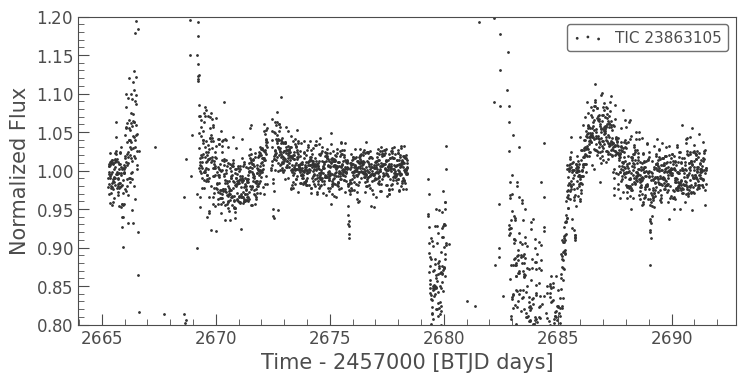

Saved:  ../allesfitter/toi5671/tess.csv
                     time      flux  flux_err
time                                         
2665.278284  2.459665e+06  0.978467  0.020122
2665.285228  2.459665e+06  0.990122  0.020122
2665.292173  2.459665e+06  1.009079  0.020122
2665.299117  2.459665e+06  1.005646  0.020122
2665.306062  2.459665e+06  0.995332  0.020122


In [32]:
#!/usr/bin/env python
import lightkurve as lk

multi_sector = True
cols = ['time','flux','flux_err']

author = 'QLP'
result = lk.search_lightcurve(f'TIC {tic}', author=author)
if result:
    if multi_sector:
        lc = result.download_all().stitch()
    else:
        lc = result.download().normalize().remove_outliers()
    ax = lc.scatter()
    ax.set_ylim(0.8,1.2)
    pl.show()
    #ax.set_title(f"TOI {toi} (sector {lc.sector})")
    ax.figure.savefig(f"../allesfitter/{name}/toi{toiid}_tess.png")
    fp = f"../allesfitter/{name}/tess.csv"
    df = lc.to_pandas()
    df['time'] = df.index + 2457000
    df = df[cols].dropna()
    #import pdb; pdb.set_trace()
    df.to_csv(fp, sep=',', header=False, index=False)
    print("Saved: ", fp)
    print(df.head())

In [25]:
len(df)

2988